In [104]:
import sys
from scipy.io import savemat, loadmat
import os
PACKAGE_PARENT = '../..'
sys.path.append(PACKAGE_PARENT)

import src.utils as utils
from src.params import *
from src.regularizer import GL1
from src.lossfunction import LogisticLoss, LeastSquares
from src.schimdt.ProbGL1 import ProbGL1 as sProbGL1
from src.schimdt.Solver import Solver as sSolver

from src.naive.ProbGL1 import ProbGL1
from src.naive.Solver import Solver
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from matplotlib.pyplot import cm

In [2]:
params

{'tol': 1e-06,
 'max_iter': 10000,
 'max_time': 3600,
 'max_back': 100,
 'printlevel': 2,
 'printevery': 20,
 'eta': 0.001,
 'xi': 0.5,
 'zeta': 0.8,
 'beta': 1,
 'update_alpha_strategy': 'none',
 'optimality_measure': 'prox',
 'method': 'adaptive',
 'inexact_strategy': 'sampling',
 'max_attempts': 300,
 'warm_sampling': False,
 'init_perturb': 0,
 't': 1,
 'mode': 'whole',
 'delta': 0.001}

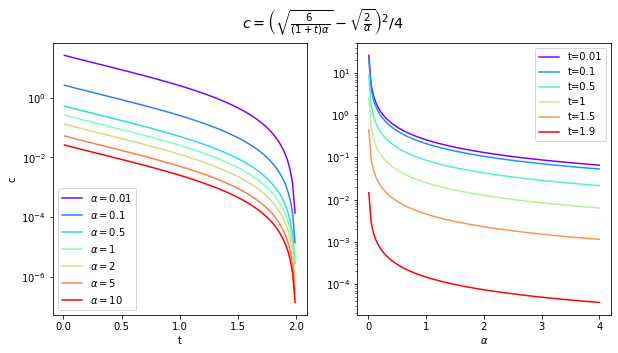

In [44]:
def cfunc(t, alpha):
    part1 = np.sqrt(6/((1+t)*alpha))
    part2 = np.sqrt(2/alpha)
    return (part1 - part2)**2 / 4

t = np.linspace(0.01, 1.99, 100)
alpha = [0.01, 0.1, 0.5, 1, 2, 5, 10]
color=iter(cm.rainbow(np.linspace(0,1,len(alpha))))
fig, axes = plt.subplots(1,2, figsize=(10,5))
for i in range(len(alpha)):
    mycolor = next(color)
    y = cfunc(t, alpha[i])
    axes[0].plot(t, y, c=mycolor, label=r'$\alpha=$'+f'{alpha[i]}')
axes[0].legend()    
axes[0].set_xlabel('t');axes[0].set_ylabel('c');
axes[0].set_yscale('log')
alpha = np.linspace(0.01, 4, 100)
t = [0.01, 0.1, 0.5, 1, 1.5, 1.9]
color=iter(cm.rainbow(np.linspace(0,1,len(t))))
for i in range(len(t)):
    mycolor = next(color)
    y = cfunc(t[i], alpha)
    axes[1].plot(alpha, y, c=mycolor, label=f't={t[i]}')
axes[1].legend()
axes[1].set_xlabel(r'$\alpha$');axes[0].set_ylabel('c');
axes[1].set_yscale('log')
fig.suptitle(r"$c=\left(\sqrt{\frac{6}{(1+t)\alpha}}-\sqrt{\frac{2}{\alpha}}\right)^2/{4}$", fontsize="x-large")
plt.savefig('/Users/ym/Dropbox (LU Student)/Apps/Overleaf/inexact Proximal gradient doc/inexactProximalGradient/figs/cplot.png', dpi=300)

In [ ]:
# t = np.linspace(0.01, 2, 100)
# alpha = np.linspace(0.01, 2, 100)

# T, A = np.meshgrid(t, alpha)
# Z = cfunc(T, A)
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot_surface(T, A, Z, rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
# ax.set_xlabel(r'$\alpha$')
# ax.set_ylabel(r'$t$')
# ax.set_zlabel('z');

### Logistic - a9a

In [2]:
datasetName = 'a9a'
loss = 'logit'
lam_shrink = 0.1
frac = 0.5
fileType = fileTypeDict[datasetName]
print("Working on: {}...".format(datasetName))
X, y = utils.set_up_xy(datasetName, fileType, dbDir='../../../db')
f = LogisticLoss(X, y, datasetName)
p = X.shape[1]
num_of_groups = max(int(p * frac), 1)
group = utils.gen_group(p, num_of_groups)
lammax_path = f'../../../db/lammax-{datasetName}-{frac}.mat'
if os.path.exists(lammax_path):
    lammax = loadmat(lammax_path)["lammax"][0][0]
    print(f"loading lammax from: {lammax_path}")
else:
    lammax = utils.lam_max(X, y, group, loss)
    savemat(lammax_path, {"lammax": lammax})
    print(f"save lammax to: {lammax_path}")
Lambda = lammax * lam_shrink
r = GL1(Lambda=Lambda, group=group)
prob = ProbGL1(f, r)
sprob = sProbGL1(f,r)

# params['beta'] = 1/0.9
# adaptive setup
params['tol'] = 1e-6
params['update_alpha_strategy'] = 'model'
params['t'] = 1e-12
params['method'] = 'adaptive'
params['init_perturb'] = 1e3
solver = Solver(prob, params)
info_perturb_adpative = solver.solve(explore=True)
# bechmark the exact case
params['init_perturb'] = 0.0
solver = Solver(prob, params)
info_exact = solver.solve(explore=True)

# prescribed setup
params['init_perturb'] = 1e3
params['method'] = 'schimdt'
params['delta'] = 1
ssolver = sSolver(sprob, params)
info_perturb_schimdt = ssolver.solve(explore=True)


Working on: a9a...
loading lammax from: ../../../db/lammax-a9a-0.5.mat

Exit: Optimal Solution Found


Exit: Optimal Solution Found


Exit: Optimal Solution Found



0.5153413538892401 0.5153413538899088 0.5153418011192625


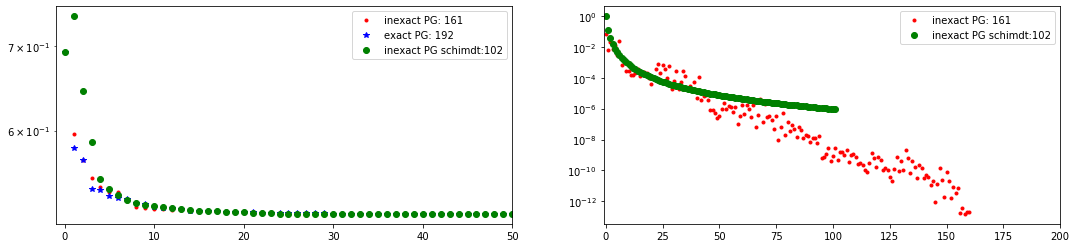

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
Fseq_inexact = info_perturb_adpative['Fseq']
Fseq_exact = info_exact['Fseq']
Fseq_schimdt = info_perturb_schimdt['Fseq']

Eseq_inexact = info_perturb_adpative['Eseq']
Eseq_schimdt = info_perturb_schimdt['Eseq']

ax1.plot(Fseq_inexact, 'r.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax1.plot(Fseq_exact, 'b*', label=f'exact PG: {len(Fseq_exact)}', )
ax1.plot(Fseq_schimdt, 'go', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax1.set_yscale('log')
ax1.set_xlim((-1, 50))
ax1.legend()

ax2.plot(Eseq_inexact, 'r.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax2.plot(Eseq_schimdt, 'go', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax2.set_yscale('log')
ax2.set_xlim((-1, 200))
ax2.legend()
print(Fseq_inexact[-1], Fseq_exact[-1], Fseq_schimdt[-1])

# Logistic w8a

In [4]:
datasetName = 'w8a'
loss = 'logit'
lam_shrink = 0.1
frac = 0.5
fileType = fileTypeDict[datasetName]
print("Working on: {}...".format(datasetName))
X, y = utils.set_up_xy(datasetName, fileType, dbDir='../../../db')
f = LogisticLoss(X, y, datasetName)
p = X.shape[1]
num_of_groups = max(int(p * frac), 1)
group = utils.gen_group(p, num_of_groups)
lammax_path = f'../../../db/lammax-{datasetName}-{frac}.mat'
if os.path.exists(lammax_path):
    lammax = loadmat(lammax_path)["lammax"][0][0]
    print(f"loading lammax from: {lammax_path}")
else:
    lammax = utils.lam_max(X, y, group, loss)
    savemat(lammax_path, {"lammax": lammax})
    print(f"save lammax to: {lammax_path}")
Lambda = lammax * lam_shrink
r = GL1(Lambda=Lambda, group=group)
prob = ProbGL1(f, r)
sprob = sProbGL1(f,r)

# params['beta'] = 1/0.9
# adaptive setup
params['tol'] = 1e-6
params['update_alpha_strategy'] = 'model'
params['t'] = 1e-12
params['method'] = 'adaptive'
params['init_perturb'] = 1e3
solver = Solver(prob, params)
info_perturb_adpative = solver.solve(explore=True)
# bechmark the exact case
params['init_perturb'] = 0.0
solver = Solver(prob, params)
info_exact = solver.solve(explore=True)

# prescribed setup
params['init_perturb'] = 1e3
params['method'] = 'schimdt'
params['delta'] = 1
ssolver = sSolver(sprob, params)
info_perturb_schimdt = ssolver.solve(explore=True)


Working on: w8a...
loading lammax from: ../../../db/lammax-w8a-0.5.mat

Exit: Optimal Solution Found


Exit: Optimal Solution Found


Exit: Optimal Solution Found



0.4353396676992113 0.43533966769752774 0.43534068566352585


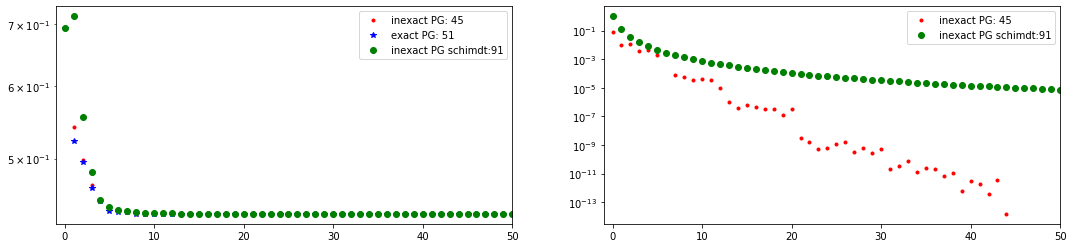

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
Fseq_inexact = info_perturb_adpative['Fseq']
Fseq_exact = info_exact['Fseq']
Fseq_schimdt = info_perturb_schimdt['Fseq']

Eseq_inexact = info_perturb_adpative['Eseq']
Eseq_schimdt = info_perturb_schimdt['Eseq']

ax1.plot(Fseq_inexact, 'r.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax1.plot(Fseq_exact, 'b*', label=f'exact PG: {len(Fseq_exact)}', )
ax1.plot(Fseq_schimdt, 'go', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax1.set_yscale('log')
ax1.set_xlim((-1, 50))
ax1.legend()

ax2.plot(Eseq_inexact, 'r.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax2.plot(Eseq_schimdt, 'go', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax2.set_yscale('log')
ax2.set_xlim((-1, 50))
ax2.legend()
print(Fseq_inexact[-1], Fseq_exact[-1], Fseq_schimdt[-1])

## Least squares -  cadata

In [3]:
datasetName = 'cadata'
loss = 'ls'
lam_shrink = 0.1
frac = 0.5
fileType = fileTypeDict[datasetName]
print("Working on: {}...".format(datasetName))
X, y = utils.set_up_xy(datasetName, fileType, dbDir='../../../db')
f = LeastSquares(X, y, datasetName)
p = X.shape[1]
num_of_groups = max(int(p * frac), 2)
group = utils.gen_group(p, num_of_groups)
lammax_path = f'../../../db/lammax-{datasetName}-{frac}.mat'
if os.path.exists(lammax_path):
    lammax = loadmat(lammax_path)["lammax"][0][0]
    print(f"loading lammax from: {lammax_path}")
else:
    lammax = utils.lam_max(X, y, group, loss)
    savemat(lammax_path, {"lammax": lammax})
    print(f"save lammax to: {lammax_path}")
Lambda = lammax * lam_shrink
r = GL1(Lambda=Lambda, group=group)
prob = ProbGL1(f, r)
sprob = sProbGL1(f,r)
params['max_attempts'] = 10000
# params['beta'] = 1/0.9
# adaptive setup
params['tol'] = 1e-10
params['update_alpha_strategy'] = 'model'
params['t'] = 1e-12
params['method'] = 'adaptive'
params['init_perturb'] = 1e3
solver = Solver(prob, params)
info_perturb_adpative = solver.solve(explore=True)
# bechmark the exact case
params['init_perturb'] = 0.0
solver = Solver(prob, params)
info_exact = solver.solve(explore=True)

# prescribed setup
params['init_perturb'] = 1e3
params['method'] = 'schimdt'
params['delta'] = 1
ssolver = sSolver(sprob, params)
info_perturb_schimdt = ssolver.solve(explore=True)


Working on: cadata...
loading lammax from: ../../../db/lammax-cadata-0.5.mat

Exit: Proximal Problem Solver Failed


Exit: Proximal Problem Solver Failed



TypeError: cannot unpack non-iterable NoneType object

0.3815957903279913 0.38154206285732317 0.38154838166190697


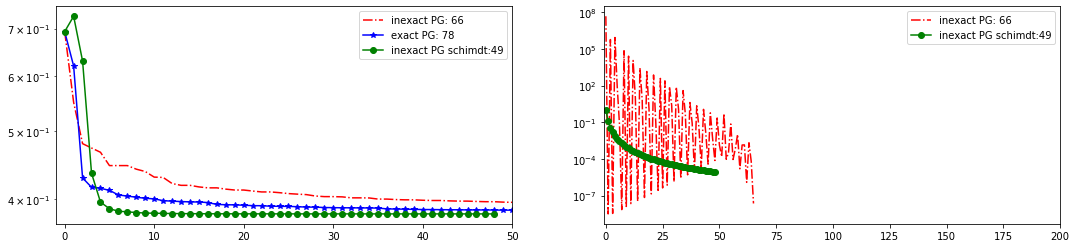

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
Fseq_inexact = info_perturb_adpative['Fseq']
Fseq_exact = info_exact['Fseq']
Fseq_schimdt = info_perturb_schimdt['Fseq']

Eseq_inexact = info_perturb_adpative['Eseq']
Eseq_schimdt = info_perturb_schimdt['Eseq']

ax1.plot(Fseq_inexact, 'r-.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax1.plot(Fseq_exact, 'b-*', label=f'exact PG: {len(Fseq_exact)}', )
ax1.plot(Fseq_schimdt, 'g-o', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax1.set_yscale('log')
ax1.set_xlim((-1, 50))
ax1.legend()

ax2.plot(Eseq_inexact, 'r-.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax2.plot(Eseq_schimdt, 'go-', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax2.set_yscale('log')
ax2.set_xlim((-1, 200))
ax2.legend()
print(Fseq_inexact[-1], Fseq_exact[-1], Fseq_schimdt[-1])

## Least squares - cpusmall

In [3]:
datasetName = 'cpusmall_scale'
loss = 'ls'
lam_shrink = 0.1
frac = 0.5
fileType = fileTypeDict[datasetName]
print("Working on: {}...".format(datasetName))
X, y = utils.set_up_xy(datasetName, fileType, dbDir='../../../db')
f = LeastSquares(X, y, datasetName)
p = X.shape[1]
num_of_groups = max(int(p * frac), 1)
group = utils.gen_group(p, num_of_groups)
lammax_path = f'../../../db/lammax-{datasetName}-{frac}.mat'
if os.path.exists(lammax_path):
    lammax = loadmat(lammax_path)["lammax"][0][0]
    print(f"loading lammax from: {lammax_path}")
else:
    lammax = utils.lam_max(X, y, group, loss)
    savemat(lammax_path, {"lammax": lammax})
    print(f"save lammax to: {lammax_path}")
Lambda = lammax * lam_shrink
r = GL1(Lambda=Lambda, group=group)
prob = ProbGL1(f, r)
sprob = sProbGL1(f,r)

# params['beta'] = 1/0.9
# adaptive setup
params['max_attempts'] = 10000
params['tol'] = 1e-6
params['update_alpha_strategy'] = 'model'
params['t'] = 1e-12
params['method'] = 'adaptive'
params['init_perturb'] = 1e3
solver = Solver(prob, params)
info_perturb_adpative = solver.solve(explore=True)
# bechmark the exact case
params['init_perturb'] = 0.0
solver = Solver(prob, params)
info_exact = solver.solve(explore=True)

# prescribed setup
params['init_perturb'] = 1e3
params['method'] = 'schimdt'
params['delta'] = 1
ssolver = sSolver(sprob, params)
info_perturb_schimdt = ssolver.solve(explore=True)


Working on: cpusmall_scale...
loading lammax from: ../../../db/lammax-cpusmall_scale-0.5.mat


KeyboardInterrupt: 

809.907602950625 809.9076029721158 809.9076031041518


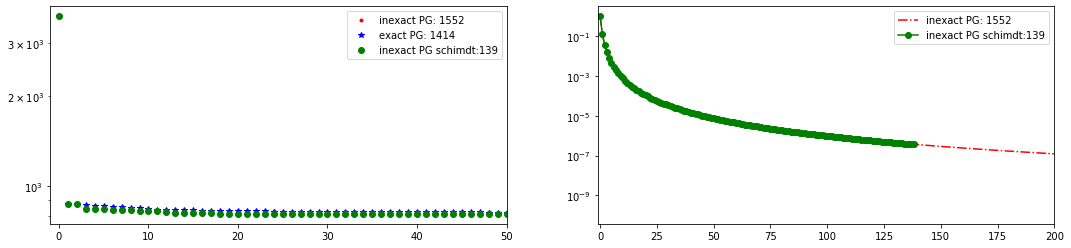

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
Fseq_inexact = info_perturb_adpative['Fseq']
Fseq_exact = info_exact['Fseq']
Fseq_schimdt = info_perturb_schimdt['Fseq']

Eseq_inexact = info_perturb_adpative['Eseq']
Eseq_schimdt = info_perturb_schimdt['Eseq']

ax1.plot(Fseq_inexact, 'r.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax1.plot(Fseq_exact, 'b*', label=f'exact PG: {len(Fseq_exact)}', )
ax1.plot(Fseq_schimdt, 'go', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax1.set_yscale('log')
ax1.set_xlim((-1, 50))
ax1.legend()

ax2.plot(Eseq_inexact, 'r-.', label=f'inexact PG: {len(Fseq_inexact)}', )
ax2.plot(Eseq_schimdt, 'go-', label=f'inexact PG schimdt:{len(Fseq_schimdt)}', )
ax2.set_yscale('log')
ax2.set_xlim((-1, 200))
ax2.legend()
print(Fseq_inexact[-1], Fseq_exact[-1], Fseq_schimdt[-1])